In [22]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

base_path = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

if base_path not in sys.path:
    sys.path.insert(0, base_path)

from app.app_config import AppConfig
from infra.spark.spark_session import SparkSessionFactory

spark = SparkSessionFactory.create("pipelines-process")

✅ SparkSession ready | mode=local | spark=3.5.6
Driver python: C:\Users\Praca\AppData\Local\Programs\Python\Python312\python.exe
Executor python: C:\Users\Praca\AppData\Local\Programs\Python\Python312\python.exe


In [23]:
silver_df = (
    spark.read
    .format("delta")
    .load(AppConfig.SILVER_STATE_PATH)
)

silver_df.printSchema()
silver_df.select("simulation_id").distinct().show(truncate=False)

SIM_ID = "413af5eb-5ab8-438f-b8e1-5b210dcd2828"

one_sim_df = (
    silver_df
    .filter(f"simulation_id = '{SIM_ID}'")
    .orderBy("step")
)

one_sim_df.count()


root
 |-- simulation_id: string (nullable = true)
 |-- step: integer (nullable = true)
 |-- simulation_time: double (nullable = true)
 |-- rpm: double (nullable = true)
 |-- speed_kmh: double (nullable = true)
 |-- throttle: double (nullable = true)
 |-- brake: double (nullable = true)
 |-- gear: integer (nullable = true)
 |-- coolant_temp_c: double (nullable = true)
 |-- oil_temp_c: double (nullable = true)
 |-- wear_engine: double (nullable = true)
 |-- wear_gearbox: double (nullable = true)
 |-- created_at: timestamp (nullable = true)

+------------------------------------+
|simulation_id                       |
+------------------------------------+
|c43d99ce-7afb-4f56-988b-6b6c5b1c49d0|
|75b1b44c-b1ae-422e-90b1-66027ac4de75|
|549cf669-e30d-40c3-8c1d-71037b426a14|
|0c7b9175-e73e-44d7-8ce2-ea750bacdcf0|
|413af5eb-5ab8-438f-b8e1-5b210dcd2828|
|127876df-3a18-47ad-a65b-ffedab1df14c|
+------------------------------------+



1116

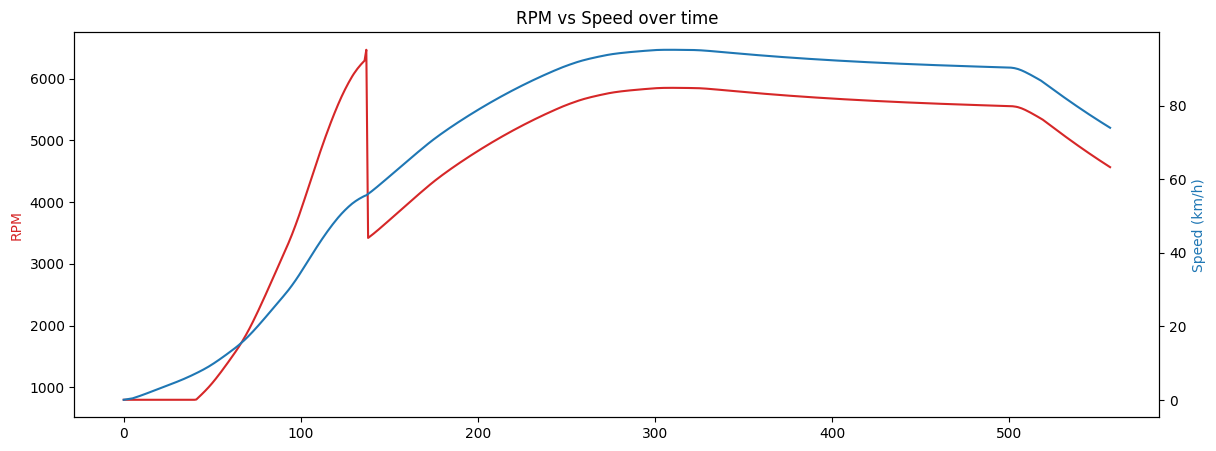

In [24]:
pdf = (
    one_sim_df
    .select("step", "rpm", "speed_kmh", "gear")
    .toPandas()
)

fig, ax1 = plt.subplots(figsize=(14,5))

ax1.plot(pdf["step"], pdf["rpm"], label="RPM", color="tab:red")
ax1.set_ylabel("RPM", color="tab:red")

ax2 = ax1.twinx()
ax2.plot(pdf["step"], pdf["speed_kmh"], label="Speed (km/h)", color="tab:blue")
ax2.set_ylabel("Speed (km/h)", color="tab:blue")

plt.title("RPM vs Speed over time")
plt.show()


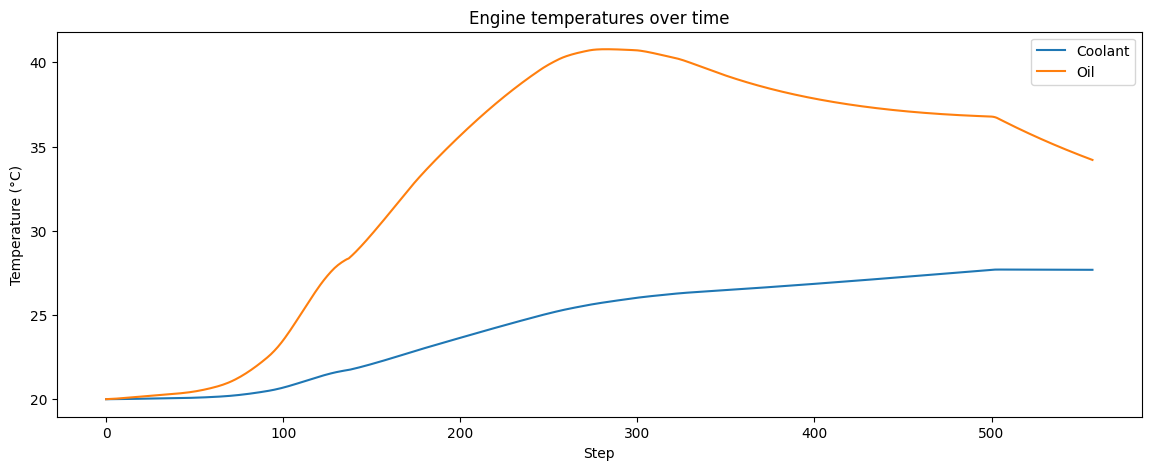

In [25]:
pdf = (
    one_sim_df
    .select("step", "rpm", "coolant_temp_c", "oil_temp_c")
    .toPandas()
)

plt.figure(figsize=(14,5))
plt.plot(pdf["step"], pdf["coolant_temp_c"], label="Coolant")
plt.plot(pdf["step"], pdf["oil_temp_c"], label="Oil")
plt.xlabel("Step")
plt.ylabel("Temperature (°C)")
plt.title("Engine temperatures over time")
plt.legend()
plt.show()


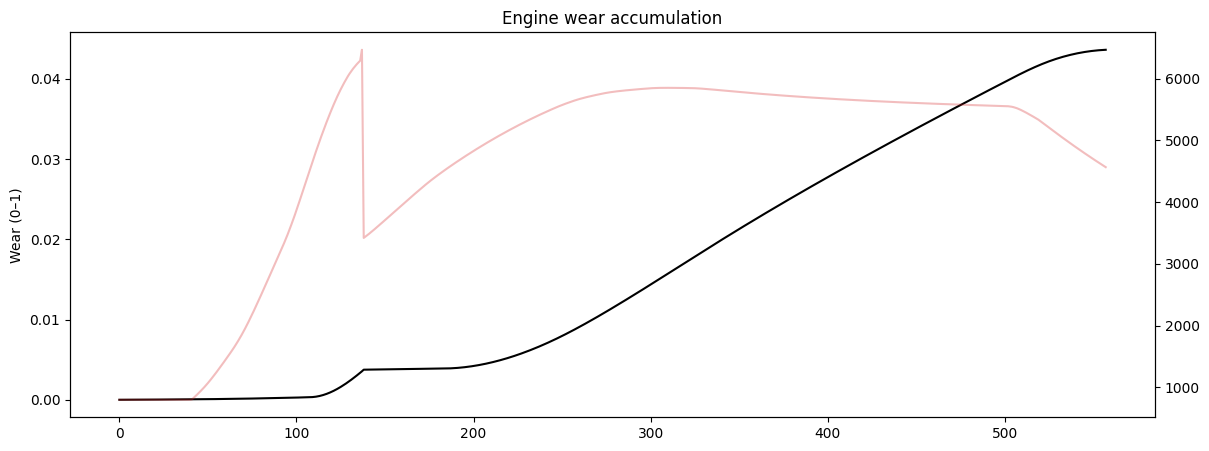

In [26]:
pdf = (
    one_sim_df
    .select("step", "wear_engine", "rpm", "coolant_temp_c")
    .toPandas()
)

fig, ax1 = plt.subplots(figsize=(14,5))

ax1.plot(pdf["step"], pdf["wear_engine"], label="Engine wear", color="black")
ax1.set_ylabel("Wear (0–1)")

ax2 = ax1.twinx()
ax2.plot(pdf["step"], pdf["rpm"], alpha=0.3, label="RPM", color="tab:red")

plt.title("Engine wear accumulation")
plt.show()


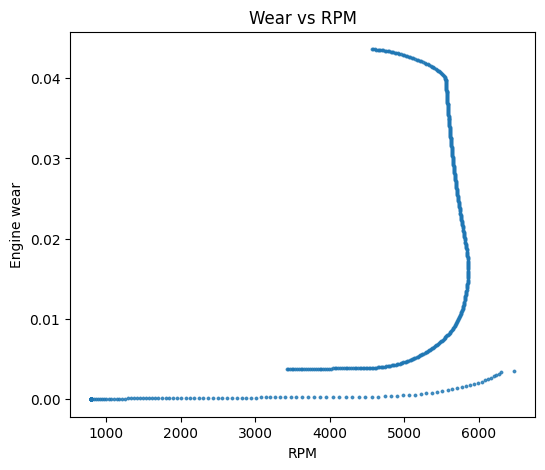

In [27]:
pdf = (
    one_sim_df
    .select("rpm", "wear_engine")
    .toPandas()
)

plt.figure(figsize=(6,5))
plt.scatter(pdf["rpm"], pdf["wear_engine"], s=3, alpha=0.5)
plt.xlabel("RPM")
plt.ylabel("Engine wear")
plt.title("Wear vs RPM")
plt.show()


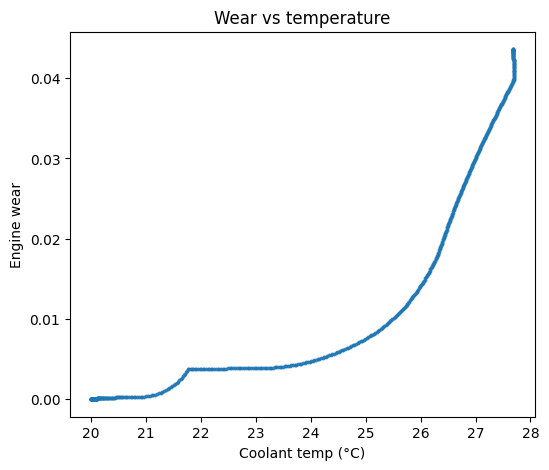

In [28]:
pdf = (
    one_sim_df
    .select("coolant_temp_c", "wear_engine")
    .toPandas()
)

plt.figure(figsize=(6,5))
plt.scatter(pdf["coolant_temp_c"], pdf["wear_engine"], s=3, alpha=0.5)
plt.xlabel("Coolant temp (°C)")
plt.ylabel("Engine wear")
plt.title("Wear vs temperature")
plt.show()
